In [1]:
import pandas as pd
import geopandas as gpd
import xarray as xr
import numpy as np
import itertools

from pathlib import Path
from tqdm.auto import tqdm
from ast import literal_eval

%matplotlib widget
import matplotlib.pyplot as plt

datasets = Path("/work/pi_kandread_umass_edu/Datasets/")
save_dir = Path("/work/pi_kandread_umass_edu/tss-ml/data/NA_WQP/")
site_list_dir = save_dir/'metadata'/'site_lists'

fig_dir = save_dir / "figures"
fig_dir.mkdir(exist_ok=True)
target_crs = "ESRI:102004"

polygons = gpd.read_file(save_dir/"metadata"/'site_basin_polygons.shp', engine="pyogrio")
polygons = polygons.set_index('wqp_id')

matchups = pd.read_csv(
    save_dir / "preprocess" / "hydrography_matchups.csv",
    index_col='wqp_id',
    converters={"wqp_multi_ids": literal_eval})
matchups.geometry = gpd.GeoSeries.from_wkt(matchups.geometry)
matchups = gpd.GeoDataFrame(matchups).set_crs(target_crs)

attributes = pd.read_csv(save_dir/"attributes"/"attributes.csv", index_col='index')

wqp = pd.read_parquet(save_dir / "preprocess" / 'wqp.parquet')
#Bandaid for old column names
wqp = wqp.rename(columns={'ssc_(mg/l)':'ssc',
                          'flux_(tons/day)':'flux',
                          'turbidity_(NTU)':'turbidity'})


hybas = gpd.read_file(datasets / 'HydroBASINS/hybas_na_lev01-12_v1c/hybas_na_lev04_v1c.shp')
hybas = hybas.to_crs("EPSG:5070")

print("Done!")

Done!


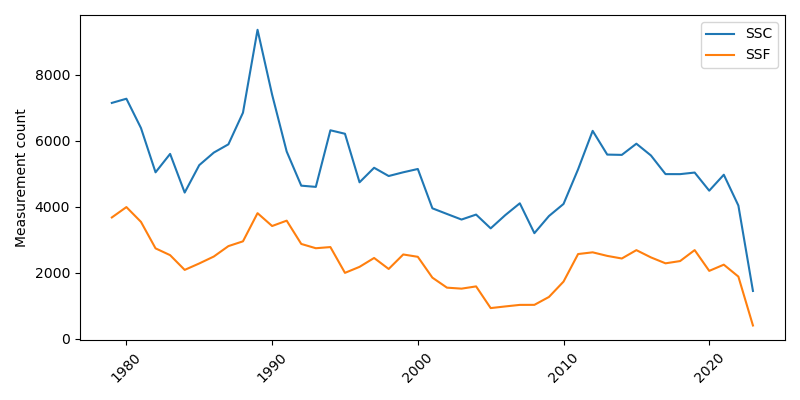

In [2]:
all_ids = [r['wqp_multi_ids'] for i,r in matchups.iterrows()]
all_ids = list(itertools.chain(*all_ids))
wqp_filt = wqp[wqp['LocationID'].isin(all_ids)].copy()


# Group by year and calculate the count for each variable
wqp_filt['year'] = wqp_filt.index.year
ssc_counts_per_year = wqp_filt.groupby('year')['ssc'].count()
flux_counts_per_year = wqp_filt.groupby('year')['flux'].count()

# Plotting the counts per year
plt.figure(figsize=(8, 4))
plt.plot(ssc_counts_per_year.index, ssc_counts_per_year, label='SSC')
plt.plot(flux_counts_per_year.index, flux_counts_per_year, label='SSF')

# Add titles and labels
plt.ylabel('Measurement count')
plt.xticks(rotation=45)
plt.legend(loc='upper right')

# Display the plot
plt.tight_layout()
plt.show()

# plt.savefig(fig_dir / "year_sed_counts.png",  dpi=300)

In [3]:
USGS_path = save_dir/"preprocess"/"raw_data"/"USGS"
counts = []
for idx,row in tqdm(matchups.iterrows(), total=len(matchups)):
    file_paths = [USGS_path/f"{wqp_id}.parquet" for wqp_id in row['wqp_multi_ids']]
    file_mask = [f.is_file() for f in file_paths]

    if not any(file_mask):
        counts.append(0)
        continue
        
    file_idx = file_mask.index(True)
    gauge = pd.read_parquet(file_paths[file_idx])
    # gauge['year'] = gauge.index.year
    counts.append(len(gauge))
    
counts = np.array(counts)
    
print(f"Gauged sites: {np.sum(counts>0)}/{len(counts)} ({100*np.mean(counts>0):0.2f}%)")

  0%|          | 0/630 [00:00<?, ?it/s]

Gauged sites: 459/630 (72.86%)


,ssc,flux,turbidity,year
date,,,,
1979-01-25 00:00:00+00:00,141.0,25200.0,50.0,1979.0
1979-03-13 00:00:00+00:00,44.0,6820.0,30.0,1979.0
1979-04-24 00:00:00+00:00,16.0,717.0,7.0,1979.0
1979-05-16 00:00:00+00:00,14.0,358.0,5.0,1979.0
1979-06-26 00:00:00+00:00,14.0,151.0,1.0,1979.0
...,...,...,...,...
2017-03-02 00:00:00+00:00,104.0,NaN,NaN,2017.0
2017-03-29 00:00:00+00:00,97.0,NaN,NaN,2017.0
2017-04-03 00:00:00+00:00,119.0,NaN,NaN,2017.0


In [29]:
all_years = pd.Series(range(1980, 2024), name="year")
var_list = ['turbidity', 'ssc', 'flux']
data = {}
for idx, row in tqdm(matchups.iterrows(), total=len(matchups)):
    combined_dict = {}
    site_wqp = wqp_filt[wqp_filt['LocationID'].isin(row['wqp_multi_ids'])]
    site_wqp = site_wqp.groupby('date').mean(numeric_only=True)
    
    for var in var_list:
        combined_dict[f"{var}_mean"] = site_wqp[var].mean()
        combined_dict[f"{var}_count"] = site_wqp[var].count()
        
        counts = site_wqp.groupby('year')[var].count()
        combined_dict[f"{var}_counts"] = counts.reindex(all_years, fill_value=0).values
    
    
    gauge_paths = [USGS_path/f"{wqp_id}.parquet" for wqp_id in row['wqp_multi_ids']]
    gauge_mask = [f.is_file() for f in gauge_paths]
    if any(gauge_mask):
        gauge_idx = gauge_mask.index(True)
        gauge = pd.read_parquet(gauge_paths[gauge_idx])
        combined_dict["q_count"] = gauge['discharge_cms'].count()
        
        gauge['year'] = gauge.index.year
        counts = gauge.groupby('year')['discharge_cms'].count()
        combined_dict["q_counts"] = counts.reindex(all_years, fill_value=0).values
    else:
        combined_dict["q_count"] = 0
        combined_dict["q_counts"] = np.array([0 for _ in range(len(all_years))])
 
    data[idx] = combined_dict
    
wqp_summary = pd.DataFrame.from_dict(data, orient='index')  

metadata = polygons[['geometry']].join(attributes, how='inner').join(wqp_summary,how='inner')
var_list.append('q')

# metadata.reset_index()['wqp_id'].to_csv(site_list_dir/'all_sites.txt', header=False, index=False)

  0%|          | 0/630 [00:00<?, ?it/s]

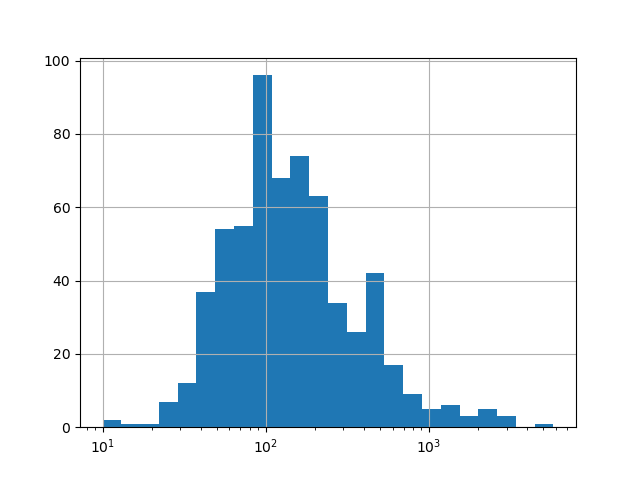

In [30]:
plt.close('all')

x = wqp_summary['ssc_count']
MIN, MAX = x.min(), x.max()
MIN = MIN if MIN>0 else 10
bins = 10 ** np.linspace(np.log10(MIN), np.log10(MAX), 25)

x.hist(bins=bins)
plt.xscale('log')

In [31]:
split_idx = np.nonzero(np.arange(1980,2022)==2014)[0][0]

for idx, row in metadata.iterrows():
    for var in var_list:
        metadata.loc[idx,f'all_{var}'] = row[f'{var}_count']
        metadata.loc[idx,f'train_{var}'] = row[f'{var}_counts'][:split_idx].sum()
        metadata.loc[idx,f'test_{var}'] = row[f'{var}_counts'][split_idx:].sum()

metadata['all_sed'] = metadata['ssc_count'] + metadata['flux_count']
metadata['train_sed'] = metadata['train_ssc'] + metadata['train_flux']
metadata['test_sed'] = metadata['test_ssc'] + metadata['test_flux']

metadata['no_sed'] = (metadata['train_sed'] == 0) & (metadata['test_sed'] == 0)
metadata['train_only'] = (metadata['train_sed'] > 0) & (metadata['test_sed'] == 0)
metadata['test_only'] = (metadata['test_sed'] > 0) & (metadata['train_sed'] == 0)

metadata['train_test_ratio'] = metadata['train_sed'] / metadata['test_sed'] 

print("Basin Counts")
print(f"total basins: {len(metadata)}")
print(f"no sed data: {metadata['no_sed'].sum()}")
print(f"train only: {metadata['train_only'].sum()}")
print(f"test only: {metadata['test_only'].sum()}")

print("\nSample Counts")
print(f"\tssc: {metadata['all_ssc'].sum().astype(int):,d}")
print(f"\tflux: {metadata['all_flux'].sum().astype(int):,d}")
print(f"\tq: {metadata['all_q'].sum().astype(int):,d}")

Basin Counts
total basins: 630
no sed data: 4
train only: 363
test only: 10

Sample Counts
	ssc: 158,235
	flux: 78,224
	q: 6,069,585


In [32]:
wqp_locs = matchups.merge(metadata,right_index=True, left_index=True)
wqp_locs = wqp_locs.set_geometry('geometry_x')

for idx, row in metadata.iterrows():
    for feature in var_list:
        wqp_locs.loc[idx,f'{feature}_total_count'] = row[f'{feature}_count']

In [33]:
wqp_locs = wqp_locs.to_crs(hybas.crs)

locs_with_basin = gpd.sjoin(wqp_locs, hybas[['HYBAS_ID','geometry']], how="left", predicate="within")
locs_with_basin['has_test'] = locs_with_basin['test_sed'] > 0
locs_with_basin['has_train'] = locs_with_basin['train_sed'] > 0

copy_cols = ['all_sed', 'train_sed','test_sed', 
             'all_ssc',  'train_ssc', 'test_ssc',
             'all_flux', 'train_flux', 'test_flux', 
             'all_q', 'train_q', 'test_q',
             'has_train', 'has_test']
basin_counts = locs_with_basin.groupby('HYBAS_ID')[copy_cols].sum().reset_index()
basin_counts['train_only'] = basin_counts['test_sed'] == 0
basin_counts['test_only'] = basin_counts['train_sed'] == 0

In [34]:
def get_next_basin(source_df, target_df, column, n_basins=1):
    for _ in range(n_basins):
        if len(source_df)==0:
            break     
        next_idx = source_df[column].argmax()
        next_basin = source_df.iloc[next_idx].copy()
        target_df = pd.concat([target_df, next_basin.to_frame().T])
        source_df.drop(next_basin.name, inplace=True)
    
    return source_df, target_df

In [37]:
# LLO site optimized splitting.

splitting_df = wqp_locs.copy()

train = pd.DataFrame()
test = pd.DataFrame()

while len(splitting_df)>0:
    splitting_df, test = get_next_basin(splitting_df, test, 'all_sed')
    splitting_df, train = get_next_basin(splitting_df, train, 'all_sed', 4)
    
train = gpd.GeoDataFrame(train, geometry=train['geometry_x'])
test = gpd.GeoDataFrame(test, geometry=test['geometry_x'])

print("Basin Counts")
print(f"train: {len(train)}")
print(f"test: {len(test)}")

print("\nSample Counts")
print(f"train: {train['all_sed'].sum().astype(int):,d}")
print(f"\tssc: {train['all_ssc'].sum().astype(int):,d}")
print(f"\tflux: {train['all_flux'].sum().astype(int):,d}")
print(f"\tq: {train['all_q'].sum().astype(int):,d}")
print(f"test: {test['all_sed'].sum().astype(int):,d}")
print(f"\tssc: {test['all_ssc'].sum().astype(int):,d}")
print(f"\tflux: {test['all_flux'].sum().astype(int):,d}")
print(f"\tQ: {test['all_q'].sum().astype(int):,d}")

train_file_path = site_list_dir / 'LLO_sites_train_sites.txt'
train.reset_index()['index'].to_csv(train_file_path, header=False, index=False)

test_file_path = site_list_dir / 'LLO_sites_test_sites.txt'
test.reset_index()['index'].to_csv(test_file_path, header=False, index=False)

Basin Counts
train: 504
test: 126

Sample Counts
train: 186,265
	ssc: 125,257
	flux: 61,008
	q: 4,779,093
test: 50,194
	ssc: 32,978
	flux: 17,216
	Q: 1,290,492


In [32]:
# LLTO site optimized splitting.

splitting_df = wqp_locs.copy()

train = splitting_df[splitting_df['train_only']]
splitting_df.drop(train.index, inplace=True)
test = splitting_df[splitting_df['test_only']]
splitting_df.drop(test.index, inplace=True)


while len(splitting_df)>0:
    splitting_df, test = get_next_basin(splitting_df, test, 'test_sed')
    splitting_df, train = get_next_basin(splitting_df, train, 'train_sed', 4)

train = gpd.GeoDataFrame(train, geometry=train['geometry_x'])
test = gpd.GeoDataFrame(test, geometry=test['geometry_x'])
    
print("Basin Counts")
print(f"train: {len(train)}")
print(f"test: {len(test)}")

print("\nSample Counts")
print(f"train: {train['train_sed'].sum().astype(int):,d}")
print(f"\tssc: {train['train_ssc'].sum().astype(int):,d}")
print(f"\tflux: {train['train_flux'].sum().astype(int):,d}")
print(f"test: {test['test_sed'].sum().astype(int):,d}")
print(f"\tssc: {test['test_ssc'].sum().astype(int):,d}")
print(f"\tflux: {test['test_flux'].sum().astype(int):,d}")

train_file_path = site_list_dir / 'LLTO_sites_train_sites.txt'
train.reset_index()['index'].to_csv(train_file_path, header=False, index=False)

test_file_path = site_list_dir / 'LLTO_sites_test_sites.txt'
test.reset_index()['index'].to_csv(test_file_path, header=False, index=False)

Basin Counts
train: 568
test: 62

Sample Counts
train: 239,018
	ssc: 164,853
	flux: 74,165
test: 33,876
	ssc: 22,199
	flux: 11,677


In [137]:
# LLO BASINS optimized splitting.

splitting_df = basin_counts.copy()

train = pd.DataFrame()
test = pd.DataFrame()

while len(splitting_df)>0:
    splitting_df, test = get_next_basin(splitting_df, test, 'all_sed')
    splitting_df, train = get_next_basin(splitting_df, train, 'all_sed', 4)
    
train = locs_with_basin[locs_with_basin['HYBAS_ID'].isin(train['HYBAS_ID'])]
test = locs_with_basin[locs_with_basin['HYBAS_ID'].isin(test['HYBAS_ID'])]

print("Basin Counts")
print(f"train: {len(train)}")
print(f"test: {len(test)}")

print("\nSample Counts")
print(f"train: {train['all_sed'].sum().astype(int):,d}")
print(f"\tssc: {train['all_ssc'].sum().astype(int):,d}")
print(f"\tflux: {train['all_flux'].sum().astype(int):,d}")
print(f"test: {test['all_sed'].sum().astype(int):,d}")
print(f"\tssc: {test['all_ssc'].sum().astype(int):,d}")
print(f"\tflux: {test['all_flux'].sum().astype(int):,d}")

# train_file_path = site_list_dir / 'LLO_basins_train_sites.txt'
# train.reset_index()['wqp_id'].to_csv(train_file_path, header=False, index=False)

# test_file_path = site_list_dir / 'LLO_basins_test_sites.txt'
# test.reset_index()['wqp_id'].to_csv(test_file_path, header=False, index=False)

Basin Counts
train: 577
test: 192

Sample Counts
train: 316,845
	ssc: 222,508
	flux: 94,337
test: 106,752
	ssc: 73,929
	flux: 32,823


In [56]:
# LLTO BASINS optimized splitting.

splitting_df = basin_counts.copy()

train = splitting_df[splitting_df['train_only']]
splitting_df.drop(train.index, inplace=True)
test = splitting_df[splitting_df['test_only']]
splitting_df.drop(test.index, inplace=True)


test_count = len(basin_counts)//5
while len(splitting_df)>0:
    splitting_df, test = get_next_basin(splitting_df, test, 'has_test')
    splitting_df, train = get_next_basin(splitting_df, train, 'has_train', 4)
    
train = locs_with_basin[locs_with_basin['HYBAS_ID'].isin(train['HYBAS_ID'])]
test = locs_with_basin[locs_with_basin['HYBAS_ID'].isin(test['HYBAS_ID'])]

print("Basin Counts")
print(f"train: {len(train)}")
print(f"test: {len(test)}")

print("\nSample Counts")
print(f"train: {train['train_sed'].sum().astype(int):,d}")
print(f"\tssc: {train['train_ssc'].sum().astype(int):,d}")
print(f"\tflux: {train['train_flux'].sum().astype(int):,d}")
print(f"test: {test['test_sed'].sum().astype(int):,d}")
print(f"\tssc: {test['test_ssc'].sum().astype(int):,d}")
print(f"\tflux: {test['test_flux'].sum().astype(int):,d}")

train_file_path = site_list_dir / 'LLTO_basins_train_sites.txt'
train.reset_index()['wqp_id'].to_csv(train_file_path, header=False, index=False)

test_file_path = site_list_dir / 'LLTO_basins_test_sites.txt'
test.reset_index()['wqp_id'].to_csv(test_file_path, header=False, index=False)

Basin Counts
train: 573
test: 196

Sample Counts
train: 205,154
	ssc: 143,047
	flux: 62,107
test: 29,978
	ssc: 17,784
	flux: 12,194


In [ ]:
list(metadata)

In [ ]:
splitting_df = metadata[~metadata['no_sed']].copy()

train = splitting_df[splitting_df['train_only']]
splitting_df.drop(train.index, inplace=True)
test = splitting_df[splitting_df['test_only']]
splitting_df.drop(test.index, inplace=True)

test_count = len(metadata)//5
while len(test) < test_count:
    next_test_idx = splitting_df['test_sed'].argmax()
    next_test = splitting_df.iloc[next_test_idx].copy()
    test = pd.concat([test, next_test.to_frame().T])
    splitting_df.drop(next_test.name, inplace=True)
    
    next_train_idx = splitting_df['train_sed'].argmax()
    next_train = splitting_df.iloc[next_train_idx].copy()
    train = pd.concat([train, next_train.to_frame().T])
    splitting_df.drop(next_train.name, inplace=True)
    
if len(splitting_df)>0:
    train = pd.concat([train, splitting_df])

print("Basin Counts")
print(f"train: {len(train)}")
print(f"test: {len(test)}")

print("\nSample Counts")
print(f"train: {train['train_sed'].sum().astype(int)}")
print(f"\tssc: {train['train_ssc'].sum().astype(int)}")
print(f"\tflux: {train['train_flux'].sum().astype(int)}")
print(f"test: {test['test_sed'].sum().astype(int)}")
print(f"\tssc: {test['test_ssc'].sum().astype(int)}")
print(f"\tflux: {test['test_flux'].sum().astype(int)}")

# train_file_path = save_dir/'metadata'/'site_lists'/'better_train_sites.txt'
# train.reset_index()['index'].to_csv(train_file_path, header=False, index=False)

# test_file_path = save_dir/'metadata'/'site_lists'/'better_test_sites.txt'
# test.reset_index()['index'].to_csv(test_file_path, header=False, index=False)

In [ ]:
import random

train_file_path = save_dir/'metadata'/'site_lists'/'better_train_sites.txt'
sites = pd.read_csv(train_file_path,header=None)[0].values

output_dir = Path("/work/pi_kandread_umass_edu/tss-ml/data/NA_WQP/metadata/site_lists/k_folds")
num_folds = 4

# Shuffle the sites randomly
random.shuffle(sites)

# Calculate the size of each fold
fold_size = len(sites) // num_folds

# Create the output directory if it doesn't exist
Path(output_dir).mkdir(parents=True, exist_ok=True)

# Split the sites into folds and create train/test files
for i in range(num_folds):
    # Define the test set for this fold
    test_start = i * fold_size
    test_end = (i + 1) * fold_size if i < num_folds - 1 else len(sites)
    test_sites = sites[test_start:test_end]

    # Define the train set (all sites not in the test set)
    train_sites = [site for site in sites if site not in test_sites]

    # Write train file
    train_filename = f"train_{i}.txt"
    with open(output_dir / train_filename, 'w') as f:
        f.write('\n'.join(train_sites))

    # Write test file
    test_filename = f"test_{i}.txt"
    with open(output_dir / test_filename, 'w') as f:
        f.write('\n'.join(test_sites))

In [ ]:
train

In [ ]:
train

In [ ]:
test['all_ssc']

np.float64(0.2523809523809524)

In [ ]:
help(bbox)

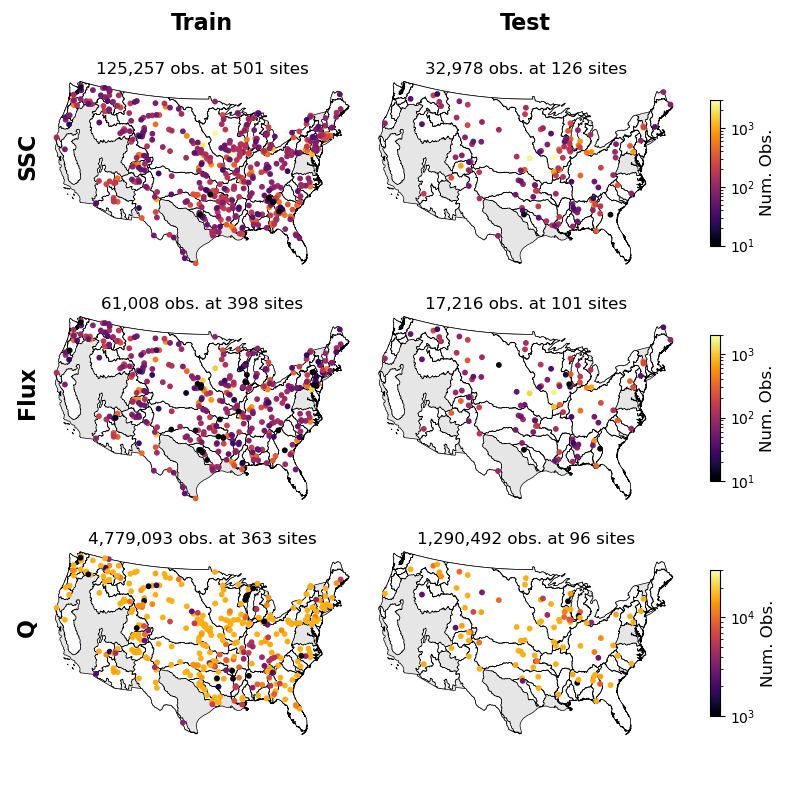

In [38]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from itertools import product
import numpy as np

outlines = gpd.read_file(datasets / 'Mapping/US_outlines/Contiguous_cb_2018_us_nation_20m/cb_2018_us_nation_20m.shp')
outlines = outlines.to_crs("EPSG:5070")

clipped_hybas = gpd.clip(hybas, outlines)

hybas_ids_with_obs = clipped_hybas.sjoin(matchups.to_crs(hybas.crs), how='inner')['PFAF_ID'].unique()
hybas_with_obs_mask = clipped_hybas['PFAF_ID'].isin(hybas_ids_with_obs)
clipped_hybas = clipped_hybas[hybas_with_obs_mask]
# hybas_facecolor = ['none' if b else '#e6e6e6' for b in hybas_with_obs_mask]

# norm = Normalize(vmin=0, vmax=500)
# norm = LogNorm(vmin=1E1, vmax=5E3)

def make_count_plot(axes, train_gdf, test_gdf, norm, col):
    for ax, gdf in zip(axes, [train_gdf, test_gdf]):
        outlines.plot(ax=ax, facecolor='#e6e6e6', edgecolor='black', linewidth=0.5)
        clipped_hybas.plot(ax=ax, facecolor='#ffffff', edgecolor='black', linewidth=0.5)

        gdf[col] = gdf[col].astype(int)
        gdf = gdf[gdf[col]>0]
        gdf.plot(col, markersize=10, ax=ax, cmap='inferno', norm=norm)

        ax.set_title(f"{int(gdf[col].sum()):,d} obs. at {len(gdf)} sites", y=0.95)
        ax.set_axis_off()

    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap='inferno', norm=norm)
    cbar = fig.colorbar(sm, ax=axes[2], 
                        shrink=0.7, 
                        fraction=0.3,
                        aspect=15, 
                        pad=0)
    cbar.set_label('Num. Obs.', fontsize=12)
    axes[2].set_axis_off()
    
    return axes

features = ['SSC', 'Flux','Q']

norms = [
    LogNorm(vmin=1E1, vmax=3E3),
    LogNorm(vmin=1E1, vmax=2E3),
    LogNorm(vmin=1E3, vmax=3E4)
]

plt.close('all')
fig, axes = plt.subplots(3, 3, figsize=(8,8), gridspec_kw={'width_ratios': [10, 10, 1]})


for axes_row, norm, feature in zip(axes, norms, features):
    col = f'all_{feature.lower()}'
    make_count_plot(axes_row, train, test, norm, col)
    
right = 0.9
top = 0.98
bottom = 0
left = 0.05
wspace = 0
hspace = -0.25
fig.subplots_adjust(right=right, top=top, bottom=bottom, left=left, wspace=wspace, hspace=hspace)

# Add column labels (subsets)
for j, subset in enumerate(['Train','Test']):
    bbox = axes[0,j].get_position()
    x = (bbox.x0 + bbox.x1)/2
    fig.text(x, 0.97, subset, ha='center', va='center', fontsize=16, fontweight='bold')

# Add row labels (features)
for i, feature in enumerate(features):
    bbox = axes[i,0].get_position()
    y = (bbox.y0 + bbox.y1)/2 + 0.02
    fig.text(0.02, y, feature, rotation=90, va='center', fontsize=16, fontweight='bold')


plt.show()

fig.savefig(fig_dir / "LLO_Sites_map.png",  dpi=300)

In [ ]:
233613+62824

In [ ]:
ax.flatten()

In [ ]:
list(metadata)

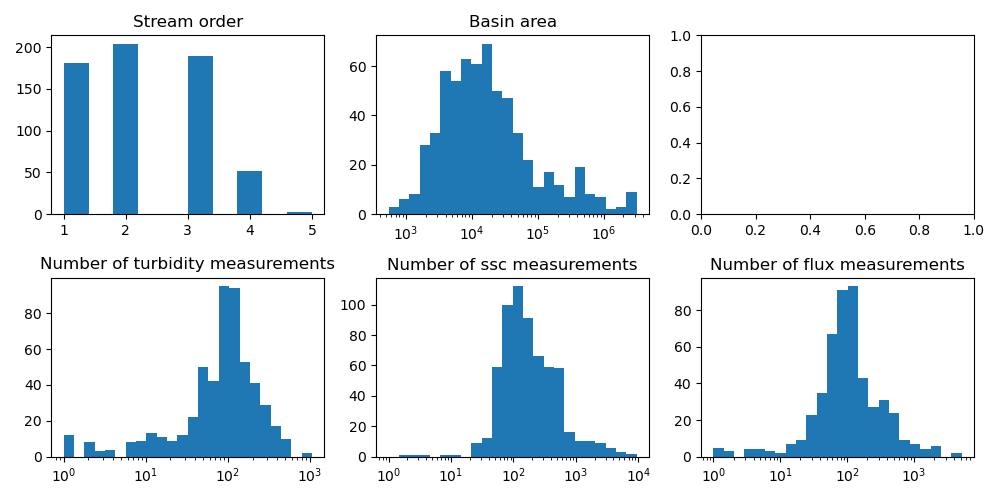

In [34]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10,5))

axes[0,0].hist(metadata["order"])
axes[0,0].set_title("Stream order")

bins = np.logspace(np.log10(min(metadata["area"])),np.log10(max(metadata["area"])), 25)
axes[0,1].hist(metadata["area"], bins=bins)
axes[0,1].set_xscale("log")
axes[0,1].set_title("Basin area")

targets = ["turbidity","ssc","flux"]
for i, target in enumerate(targets):
    bins = np.logspace(0,np.log10(max(metadata[f"{target}_count"])), 25)
    axes[1,i].hist(metadata[f"{target}_count"],bins=bins)
    axes[1,i].set_xscale("log")
    axes[1,i].set_title(f"Number of {target} measurements")


plt.tight_layout()
plt.show()


In [ ]:
list(metadata)

In [ ]:
area = 10000 #km^2
feature = "ssc"
n_sat_obs = 50

mask = ((metadata["area"]>=area) & 
        (metadata[f"n_red_{feature}"]>= n_sat_obs))

print(np.sum(mask))
file_name = f"sites_{feature}_area{area}_n{n_sat_obs}.txt"
file_path = save_dir/"site_lists"/file_name
print(file_path)

# Save the Series to a text file with no delimiters or headers
# metadata.hybas[mask].to_csv(file_path, header=False, index=False)

metadata[mask].plot(alpha=0.2)



In [ ]:
pwd